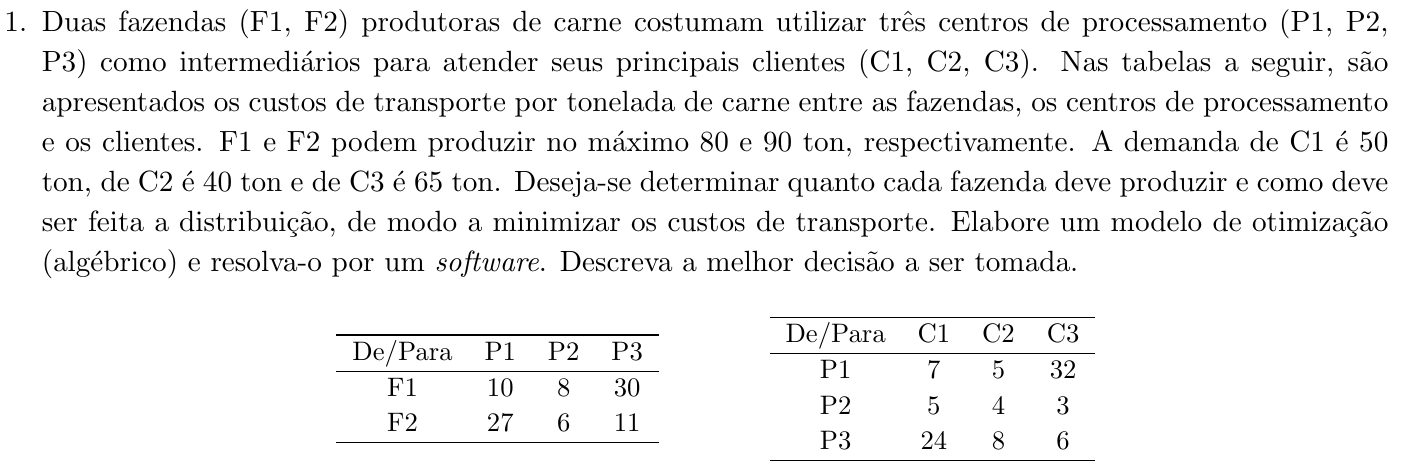

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='images/1.png')

In [8]:
# Conjuntos
Fazendas = ['F1', 'F2']
Processamento = ['P1', 'P2', 'P3']
Clientes = ['C1', 'C2', 'C3']
# Dados
c_transporte_F_P = {('F1', 'P1'): 10, ('F1', 'P2'): 8, ('F1', 'P3'): 30,
                    ('F2', 'P1'): 27, ('F2', 'P2'): 6, ('F2', 'P3'): 11}
c_transporte_P_C = {('P1', 'C1'): 7, ('P1', 'C2'): 5, ('P1', 'C3'): 32,
                    ('P2', 'C1'): 5, ('P2', 'C2'): 4, ('P2', 'C3'): 3,
                    ('P3', 'C1'): 24, ('P3', 'C2'): 8, ('P3', 'C3'): 6}
prod_max_F = {'F1': 80, 'F2': 90}
demanda = {'C1': 50, 'C2': 40, 'C3': 65}

In [9]:
# Módulos
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [10]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.F = Set(initialize=Fazendas)
model.P = Set(initialize=Processamento)
model.C = Set(initialize=Clientes)
F = model.F
P = model.P
C = model.C

# Parâmetros
model.c = Param(F * P, initialize=c_transporte_F_P, within=NonNegativeReals)
model.g = Param(P * C, initialize=c_transporte_P_C, within=NonNegativeReals)
model.u = Param(F, initialize=prod_max_F, within=NonNegativeReals)
model.d = Param(C, initialize=demanda, within=NonNegativeReals)
c = model.c
g = model.g
u = model.u
d = model.d

# Variáveis de decisão
model.x = Var(F, within=NonNegativeReals)
model.y = Var(F * P, within=NonNegativeReals)
model.z = Var(P * C, within=NonNegativeReals)
x = model.x
y = model.y
z = model.z

# Função objetivo
model.obj = Objective(sense=minimize,
                      expr = (sum(sum(c[i,j] * y[i,j] for i in F) for j in P) + 
                              sum(sum(g[j,k] * z[j,k] for k in C) for j in P)))

# Restrições
# Produção máxima
model.r_max = ConstraintList()
for i in F:
    model.r_max.add(expr = x[i] <= u[i])
# Demanda
model.r_demanda = ConstraintList()
for k in C:
    model.r_demanda.add(expr = sum(z[j,k] for j in P) >= d[k])
# Entra = Sai
model.r_balanco = ConstraintList()
for j in P:
    model.r_balanco.add(expr = sum(y[i,j] for i in F) == sum(z[j,k] for k in C))
# Produção
model.r_producao = ConstraintList()
for i in F:
    model.r_producao.add(expr = x[i] == sum(y[i,j] for j in P))

# model.pprint()

In [11]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee = False)

In [12]:
# Apresentação de resultados
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    print('Quantidade produzida nas fazendas:')
    for i in F:
        print('A quantidade produzida em {} é de {} toneladas.'.format(i, value(x[i])))
    print()
    print('Quantidades transportadas das fazendas aos centros de processamento:')
    for i in F:
        for j in P:
            print('{} ton. de carne vão da {} a {}'.format(value(y[i,j]), i, j))
    print()
    print('Quantidades transportadas dos centros de processamento aos clientes:')
    for j in P:
        for k in C:
            print('{} ton. de carne vão de {} a {}'.format(value(z[j,k]), j, k))
else:
    print(resultado.solver.termination_condition)

print()
print('O custo mínimo obtido é de R${:.2f}'.format(model.obj.expr()))

Quantidade produzida nas fazendas:
A quantidade produzida em F1 é de 65.0 toneladas.
A quantidade produzida em F2 é de 90.0 toneladas.

Quantidades transportadas das fazendas aos centros de processamento:
0.0 ton. de carne vão da F1 a P1
65.0 ton. de carne vão da F1 a P2
0.0 ton. de carne vão da F1 a P3
0.0 ton. de carne vão da F2 a P1
90.0 ton. de carne vão da F2 a P2
0.0 ton. de carne vão da F2 a P3

Quantidades transportadas dos centros de processamento aos clientes:
0.0 ton. de carne vão de P1 a C1
0.0 ton. de carne vão de P1 a C2
0.0 ton. de carne vão de P1 a C3
50.0 ton. de carne vão de P2 a C1
40.0 ton. de carne vão de P2 a C2
65.0 ton. de carne vão de P2 a C3
0.0 ton. de carne vão de P3 a C1
0.0 ton. de carne vão de P3 a C2
0.0 ton. de carne vão de P3 a C3

O custo mínimo obtido é de R$1665.00
